<b>Data mining Project - 2020/21</b><br/>
<span>
<b>Authors:</b> <a href="http://------">Diletta Goglia</a> and <a href="http://------">Marco Petix</a><br/>
<b>Python version:</b>  3.x<br/>
<b>Last update:</b> 20/10/2020
</span>
</span>

# Data Understanding and Preparation


# Data Understanding
**Dataset description**

This notebook contains an explorative analysis of the **"customer_supermarket"** describing purchases and shopping sessions.

The data is organised in a form of an array, where the dataset attributes (aka features) are organised in columns, and the shoppig sessions (aka instances) - in rows. The dataset consists of several data categories describing purchases made by customers, such as the country, basket informations, products descriptions, quantity etc. 

The data set includes 471910 data observations.


**Importing libraries and loading dataset**

In [661]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy.stats.stats import pearsonr

Read the .csv file containing the data. The first line contains the list of attributes. The data is assigned to a Pandas dataframe.

In [662]:
df = pd.read_csv('dataset/customer_supermarket.csv', sep='\t', index_col=0)

## Data semantics

The function **head()** provides the first records of the dataframe.
We use it in order to assess the correct loading of the dataset and to provide a example of the records contained within it.

In [663]:
print(df.head()) #print the first records of a df
print()
#print(df.tail()) #print the last records of a df

  BasketID      BasketDate  Sale  CustomerID CustomerCountry  ProdID  \
0   536365  01/12/10 08:26  2,55    17850.00  United Kingdom  85123A   
1   536365  01/12/10 08:26  3,39    17850.00  United Kingdom   71053   
2   536365  01/12/10 08:26  2,75    17850.00  United Kingdom  84406B   
3   536365  01/12/10 08:26  3,39    17850.00  United Kingdom  84029G   
4   536365  01/12/10 08:26  3,39    17850.00  United Kingdom  84029E   

                             ProdDescr  Qta  
0   WHITE HANGING HEART T-LIGHT HOLDER    6  
1                  WHITE METAL LANTERN    6  
2       CREAM CUPID HEARTS COAT HANGER    8  
3  KNITTED UNION FLAG HOT WATER BOTTLE    6  
4       RED WOOLLY HOTTIE WHITE HEART.    6  



### Types of Attributes and basic checks

Check the data integrity, that is whether there are any empty cells or corrupted data. The Pandas function **info()** is used in order to obtain preliminary information on the dataset.
It highlights the data type and counts the number of not-null values for each column of the dataset.

In [664]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BasketID         471910 non-null  object 
 1   BasketDate       471910 non-null  object 
 2   Sale             471910 non-null  object 
 3   CustomerID       406830 non-null  float64
 4   CustomerCountry  471910 non-null  object 
 5   ProdID           471910 non-null  object 
 6   ProdDescr        471157 non-null  object 
 7   Qta              471910 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 32.4+ MB


The aforementioned function, other than identifying 471910 as the total number of records contained within the dataframe, highlights:
1. the inability of Pandas to recognize the values of *BasketDate* as datetime;
2. the misinterpretation of the values of the attribute *Sale*, being represented as objects and not real numbers, due to the use of the **comma as delimiter for decimal values**;
3. the presence of **missing values** within the attributes *CustomerID* and *ProdDescr*;
4. the presence of **non numerical values** within the attributes *BasketID* and *ProductID*, despite an expectation at a first intuitive level could suggest them to be integer.

Moreover, we notice that we only have attributes of the type **categorical**, **numeric** and **ratio-scaled** (there are not 'binary' and 'ordinal' types of data).

Here we present a classification of these attributes by type:

- Categorical Attributes:<br>
    - *BasketID*
    - *CustomerID*
    - *CustomerCountry*
    - *ProdID*
    - *ProdDescr*

- Numerical Attributes:<br>
    - *BasketDate*
    - *Sale*
    - *Qta*

### Type conversion

Now we address the first two issues.

So since,
+ *BasketDate* should be a datetime 
+ *Sale* should be a float dtype

we:

- **A.** convert *BasketDate* attribute into the right datatype using **pd.to_datetime**.
- **B.** substitute the commas with dots in the *Sale* column and convert it from object to float type using Pandas **astype()** method.

We will address the issue number 3. about missing values in the corresponding section **"1.1.3. Missing values "**.


In [665]:
# converting 'BasketDate' to datetime
pd.to_datetime(df['BasketDate'])

0        2010-01-12 08:26:00
1        2010-01-12 08:26:00
2        2010-01-12 08:26:00
3        2010-01-12 08:26:00
4        2010-01-12 08:26:00
                 ...        
541905   2011-09-12 12:50:00
541906   2011-09-12 12:50:00
541907   2011-09-12 12:50:00
541908   2011-09-12 12:50:00
541909   2011-09-12 12:50:00
Name: BasketDate, Length: 471910, dtype: datetime64[ns]

In [666]:
df['Sale'] = df['Sale'].str.replace(',', '.') # replacing commas with dots
df['Sale'].head() 

0    2.55
1    3.39
2    2.75
3    3.39
4    3.39
Name: Sale, dtype: object

In [667]:
df['Sale'] = df['Sale'].astype(float) # converting 'Sale' to float type
df['Sale'].head()

0   2.55
1   3.39
2   2.75
3   3.39
4   3.39
Name: Sale, dtype: float64

This presence of commas is common when working with European data.
An alternative solution to fix it would be adding the argument **decimal = ","** to the *read_csv* function.

We check again the data types after having fixed them:

In [668]:
df.dtypes # return the type of each attribute
          # provides list of attribute with the respective type

BasketID            object
BasketDate          object
Sale               float64
CustomerID         float64
CustomerCountry     object
ProdID              object
ProdDescr           object
Qta                  int64
dtype: object

****CustomerID* as a float or an object**

Notice how tinkering with the decimals delimiter makes Pandas recognize the *CustomerID* values as objects and not real values.

It could be possible to solve this issue by :
- explicitly casting the type of the CustomerID column as float or
- dropping the aforementioned column from the original dataframe, extracting it again from the csv file and subsequently joining the old and new dataframes. (this process is presented below as an example)

In [669]:
# df_2 = pd.read_csv('customer_supermarket.csv', sep='\t', index_col=0, usecols=[0, 4])
# df.drop(['CustomerID'], axis=1, inplace=True)
# df = df.join(df_2)

But, given the function as index of the attribute in question, its representation as a numeric data is not useful for the purposes of our analysis and, therefore, neither of the two solutions is applied.

Another possible solution:

In [670]:
# df['CustomerID'] = df['CustomerID'].astype(float) 

But before doing this, we must fill all the null values (see section ***Data Cleaning & Transformation***).

### Unique values
Using the function **unique()** we can see unique values occuring in each categorical column.

In [671]:
print("There are ", df.CustomerCountry.unique().size, "distinct countries, which are: \t") 
print(df.CustomerCountry.unique(), "\n\n")
print("There are", df.BasketID.unique().size, "distinct baskets (i.e. shopping sessions). ") 
print("There are", df.CustomerID.unique().size, "distinct customers. ") 
print("There are", df.ProdID.unique().size, "distinct products bought. ") 

There are  38 distinct countries, which are: 	
['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Bahrain' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA'] 


There are 24627 distinct baskets (i.e. shopping sessions). 
There are 4373 distinct customers. 
There are 3953 distinct products bought. 


## Data Quality
### Duplicates

In [672]:
duplicates = df.duplicated()
duplicates

0         False
1         False
2         False
3         False
4         False
          ...  
541905    False
541906    False
541907    False
541908    False
541909    False
Length: 471910, dtype: bool

In [673]:
for dupl in duplicates:
    if dupl == 'True':
        print (dupl)
        
print("Duplicate records not found")

Duplicate records not found


In [674]:
# df[duplicates]

### Missing values detection


As discovered in the ***Data semantic*** section:
+ *CustomerID* has only 406830 non-null entries
+ *ProdDescr* has only 471157 non-null entries


We confirm the assumption about the presence of missing values within the dataset by making use of the pandas function **isnull()**.

In [675]:
df.isnull().any() # True when the attribute contains at least one missing value

BasketID           False
BasketDate         False
Sale               False
CustomerID          True
CustomerCountry    False
ProdID             False
ProdDescr           True
Qta                False
dtype: bool

As previously discovered by the **info()** function, the columns *CustomerID* and *ProdDescr* are cofirmed to contain missing values.

We will find the best strategy to treat them in the ***Data Cleaning*** section.

####  Zero values
Numerical attributes like *Qta* or *Sale* might also present missing values (i.e. represented by zero values): therefore, specific code needs to be written in order to check for these cases.

We now look for values equal to zero in both of the attributes and then we reason about their meaning, to understand if zeros  can be interpreted as "missing" or not.

In [676]:
df.Qta.where(df['Qta'] == 0).count() #Zero values in Qta

0

In [677]:
df.Sale.where(df['Sale'] == 0).count() #Zero values in Sale

1279

The sales column has 1279 values equal to zero but, given the transactional
nature of the dataset under examination, we believe that the aforementioned
null values do retain a useful significance for the purposes of our analysis.

Therefore, these values are not involved in the process of replacing
missing values which instead will only involve the categorical attributes of the dataset.


#### Addictional checks on categorical attributes 

***CustomerCountry***

We compute a list of all the possible values of the *CustomerCountry* attribute.

In [678]:
df.CustomerCountry.value_counts()

United Kingdom          426261
Germany                   9495
France                    8525
EIRE                      7824
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1932
Portugal                  1495
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Unspecified                340
USA                        291
Israel                     269
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Hong Kong                  138
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

The value ***Unspecified*** is associated with 340 different records within the dataframe.
Given the inherent ambiguity of the value we consider it a **strong candidate for a replacement** with values with a stronger statistical significance.

Before committing to this decision, however, we check for the values within the *CustomerID* column of the records that present an "Unspecified" *CustomerCountry*.
Other transactions from the same customers, here represented by other records with the same value for *CustomerID*, could display different, and less ambiguous, values as their *CustomerCountry*.

We compute a list of all the values for CustomerID associated with records with an "Unspecified" *CustomerCountry*.


In [679]:
unspecified_ids = df.loc[df.CustomerCountry == 'Unspecified'].CustomerID.value_counts()
unspecified_ids.keys()

Float64Index([12743.0, 16320.0, 14265.0, 12363.0], dtype='float64')

We now check for every value of *CustomerCountry* associated with said values of *CustomerID*.

In [680]:
df.loc[df.CustomerID.isin(unspecified_ids.keys())].CustomerCountry.value_counts()

Unspecified    244
Name: CustomerCountry, dtype: int64

None of the records we have referred to are associated with a CustomerCountry other than "Unspecified".
This set of records therefore acts as an autonomous group.

While it is still possible to replace the values in question with the more frequent value of this attribute (in this case United Kingdom), we believe it is more interesting to wait for the results of the clustering process in view of a hypothetical grouping with records coming from a specific country.


***ProID***

We compute a list of all the possible values of the *ProdID* attribute.

In [681]:
df.ProdID.value_counts()

85123A    2191
22423     2042
85099B    1917
47566     1569
20725     1492
          ... 
17028J       1
35597B       1
21431        1
20954        1
90037A       1
Name: ProdID, Length: 3953, dtype: int64

The *ProdID* column presents 3953 unique values and this wide array of variety stands in the way of a deeper analysis of each single value.

### Statistics & Variable Distribution
#### Outlier detection

The pandas function **describe()** is used to obtain basic statistical notion regarding the numerical attributes of the dataset.

In [682]:
pd.options.display.float_format = '{:.2f}'.format
df.describe() # this function provides a summary of statistical informations

,Sale,CustomerID,Qta
count,471910.00,406830.00,471910.00
mean,4.03,15287.68,10.72
std,83.77,1713.60,231.36
min,-11062.06,12346.00,-80995.00
25%,1.25,13953.00,1.00
50%,2.08,15152.00,4.00
75%,3.75,16791.00,12.00
max,38970.00,18287.00,80995.00


The data provided by the function highlight:
- the presence of **negative values** within both the *Sale* and *Qta* columns.
- an high variance for both attributes, perhaps due to outliers (needs assessment via visualization).

#### Interpretation of negative values

**For *Sale* attribute**

Negative values for *Qta* attribute may be interpreted as an error to fix, while for the attribute *Sale* can be interpreted as a refound.

Now we are going to perform **addictional checks** to confirm or disprove this hypoteses and give the correct interpretation to negative values.

In [683]:
df[df['Sale'] < 0] #select records with negative sale

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
299983,A563186,12/08/11 14:51,-11062.06,nan,United Kingdom,B,Adjust bad debt,1
299984,A563187,12/08/11 14:52,-11062.06,nan,United Kingdom,B,Adjust bad debt,1


The description in *ProdDescr* column confirms that it is a refound.

In fact, according to the description associated with both records ( *ProdDescr* : "Adjust bad dept"), these transaction could be associated with some kind of refund operation.

Anyway, the statistical significance that these two isolated cases have with respect to the analysis of the dataset in question is minimal if compared to the remaining amount of data. Considering these two records as **outliers**, could therefore **improve the total reliability of the tests** conducted subsequently on the rest of the dataset.

The further discussion about removing them continues in the section ***Data Cleaning & Trasformation***.

**For *Qta* attribute**

In [684]:
df[df['Qta'] < 0] #select records with negative quantity

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
141,C536379,01/12/10 09:41,27.50,14527.00,United Kingdom,D,Discount,-1
154,C536383,01/12/10 09:49,4.65,15311.00,United Kingdom,35004C,SET OF 3 COLOURED FLYING DUCKS,-1
235,C536391,01/12/10 10:24,1.65,17548.00,United Kingdom,22556,PLASTERS IN TIN CIRCUS PARADE,-12
236,C536391,01/12/10 10:24,0.29,17548.00,United Kingdom,21984,PACK OF 12 PINK PAISLEY TISSUES,-24
237,C536391,01/12/10 10:24,0.29,17548.00,United Kingdom,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24
...,...,...,...,...,...,...,...,...
540449,C581490,09/12/11 09:57,0.83,14397.00,United Kingdom,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11
541541,C581499,09/12/11 10:28,224.69,15498.00,United Kingdom,M,Manual,-1
541715,C581568,09/12/11 11:57,10.95,15311.00,United Kingdom,21258,VICTORIAN SEWING BOX LARGE,-5
541716,C581569,09/12/11 11:58,1.25,17315.00,United Kingdom,84978,HANGING HEART JAR T-LIGHT HOLDER,-1


In [685]:
df[df.Qta < 0].ProdDescr

141                               Discount
154        SET OF 3 COLOURED  FLYING DUCKS
235         PLASTERS IN TIN CIRCUS PARADE 
236       PACK OF 12 PINK PAISLEY TISSUES 
237       PACK OF 12 BLUE PAISLEY TISSUES 
                        ...               
540449     ZINC T-LIGHT HOLDER STARS SMALL
541541                              Manual
541715          VICTORIAN SEWING BOX LARGE
541716    HANGING HEART JAR T-LIGHT HOLDER
541717       36 PENCILS TUBE RED RETROSPOT
Name: ProdDescr, Length: 9752, dtype: object

This time the records with a negative value for *Qta* are over 9000 and this amount does guarantee a stronger statistical relevance with respect to the analysis of the dataset.

So this is not an error but maybe can be interpreted as items acquired from the company instead then sold.

The values of *ProdDescr* associated with these records, however, don't provide any contextualization for the values of *Qta*.
The best hypothesis remains that one of transactions during which the company acquired (and didn't sell) some asset from the customers.

**Addictional checks to find outliers**

Now we print the highest values for *Sale* in order to see if we can find addictional outliers

In [686]:
df[df.Sale > 10000.00]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
16356,C537651,07/12/10 15:49,13541.33,nan,United Kingdom,AMAZONFEE,AMAZON FEE,-1
43703,C540118,05/01/11 09:57,16453.71,nan,United Kingdom,AMAZONFEE,AMAZON FEE,-1
222681,C556445,10/06/11 15:31,38970.00,15098.00,United Kingdom,M,Manual,-1
524601,C580604,05/12/11 11:35,11586.50,nan,United Kingdom,AMAZONFEE,AMAZON FEE,-1


# Data Preparation

## Data Cleaning & Trasformation


Now we will replace the missing values for attributes *CustomerID* and *ProdDescr*, as anticipated in section ***Missing values detection***.

### Replacing missing values
**Replacing missing values of *CustomerID***

The *CustomerID* column presents 65080 missing values.

In [687]:
df.CustomerID.isnull().sum()

65080

In order to effectively replace said values, we select the most frequent IDs in a given *CustomerCountry* (the **mode** over a subset of the dataframe) as a substitute for the missing values from that region.

These are the most frequent CustomerID for each *CustomerCountry*:

In [688]:
country_mode = df.groupby(['CustomerCountry']).agg(lambda x:x.mode()).CustomerID
print(country_mode)

CustomerCountry
Australia              12415.00
Austria                12360.00
Bahrain                12355.00
Belgium                12362.00
Brazil                 12769.00
Canada                 17444.00
Channel Islands        14936.00
Cyprus                 12359.00
Czech Republic         12781.00
Denmark                12406.00
EIRE                   14911.00
European Community     15108.00
Finland                12428.00
France                 12681.00
Germany                12471.00
Greece                 12717.00
Hong Kong                    []
Iceland                12347.00
Israel                 12688.00
Italy                  12584.00
Japan                  12753.00
Lebanon                12764.00
Lithuania              15332.00
Malta                  17828.00
Netherlands            14646.00
Norway                 12433.00
Poland                 12779.00
Portugal               12757.00
RSA                    12446.00
Saudi Arabia           12565.00
Singapore              1

No CustomerID is associated with any of the records with *CustomerCountry* equals to "Hong Kong". For the sake of replacing these empty values **we craft a custom CustomerID and add it** to the aforementioned list.

In [689]:
df.CustomerID.max()

18287.0

In [690]:
country_mode["Hong Kong"] = df.CustomerID.max()+1
country_mode["Hong Kong"]

18288.0

Now we substitute each missing value with the corresponding element from the list.

In [691]:
#We replace the missing values from CustomerID with the elements from country_mode
df['CustomerID'] = df.apply(
    lambda row: country_mode[row['CustomerCountry']] if pd.isnull(row['CustomerID']) else row['CustomerID'],
    axis=1
)

After the process the number of missing values is down to zero.

In [692]:
df.CustomerID.isnull().sum() 

0

**Necessario ???**

Now that we have replaced all the missing values for *CustomerID*, we can convert them to float (or even integer) type, as anticipated in section **DS-B**.

In [693]:
df.CustomerID.dtype

dtype('float64')

In [694]:
df.CustomerID = df.CustomerID.astype(float) 
df.CustomerID.head()

0   17850.00
1   17850.00
2   17850.00
3   17850.00
4   17850.00
Name: CustomerID, dtype: float64

In [695]:
df.CustomerID = df.CustomerID.astype(int) 
df.CustomerID.head()

0    17850
1    17850
2    17850
3    17850
4    17850
Name: CustomerID, dtype: int32

Addictional check to the dataset:

In [696]:
df.dtypes

BasketID            object
BasketDate          object
Sale               float64
CustomerID           int32
CustomerCountry     object
ProdID              object
ProdDescr           object
Qta                  int64
dtype: object

**Replacing missing values of *ProdDescr***

Since the dataset contains **ordered data**, each **sequential record / transaction** (indicated by *BasketID*) involves a set of items, described in the attribute *ProdDescr*.
The set of products purchased by a customer during one shopping trip constitute exactly a transaction (or 'session').

### Removing outliers
We now drop the two records with negative values for *Sale*, found in section ***Outliers detection***.

In [697]:
df[df['Sale'] < 0] #select records with negative sale

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
299983,A563186,12/08/11 14:51,-11062.06,17841,United Kingdom,B,Adjust bad debt,1
299984,A563187,12/08/11 14:52,-11062.06,17841,United Kingdom,B,Adjust bad debt,1


In [698]:
df = df.drop([299983,299984])

Printing again the statistics of the dataset, we can see that values for *Sale* attribute are less sparse.

In [699]:
pd.options.display.float_format = '{:.2f}'.format
df.describe() # this function provides a summary of statistical informations

,Sale,CustomerID,Qta
count,471908.00,471908.00,471908.00
mean,4.08,15635.40,10.72
std,80.61,1818.24,231.36
min,0.00,12346.00,-80995.00
25%,1.25,14099.00,1.00
50%,2.08,15658.00,4.00
75%,3.75,17557.00,12.00
max,38970.00,18288.00,80995.00


### Data Normalization
#### Min-Max approach
The "min-max feature scaling" rescales the feature to a fixed range of [0,1] by subtracting the minimum value of the feature and then dividing by the range. 

\* *Alternatively, we can use the MinMaxScaler class available in the Scikit-learn library.*

In [700]:
# apply the min-max scaling in Pandas using the .min() and .max() methods
def min_max_scaling(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in df_norm.columns:
        if ((column == float)):
            df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        
    return df_norm
    
# call the min_max_scaling function
df_normalized = min_max_scaling(df)

df_normalized

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
0,536365,01/12/10 08:26,2.55,17850,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
1,536365,01/12/10 08:26,3.39,17850,United Kingdom,71053,WHITE METAL LANTERN,6
2,536365,01/12/10 08:26,2.75,17850,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8
3,536365,01/12/10 08:26,3.39,17850,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,01/12/10 08:26,3.39,17850,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6
...,...,...,...,...,...,...,...,...
541905,581587,09/12/11 12:50,2.10,12680,France,22899,CHILDREN'S APRON DOLLY GIRL,6
541906,581587,09/12/11 12:50,4.15,12680,France,23254,CHILDRENS CUTLERY DOLLY GIRL,4
541907,581587,09/12/11 12:50,4.15,12680,France,23255,CHILDRENS CUTLERY CIRCUS PARADE,4
541908,581587,09/12/11 12:50,4.95,12680,France,22138,BAKING SET 9 PIECE RETROSPOT,3



### Correlation

We measure the correlation between the (numerical) attributes of the dataset.

In [701]:
df.corr() #method : {‘pearson’, ‘kendall’, ‘spearman’}
# Pay attention! Boolean values can be wrongly treated as integers (values 0 & 1)

,Sale,CustomerID,Qta
Sale,1.00,0.01,-0.00
CustomerID,0.01,1.00,-0.01
Qta,-0.00,-0.01,1.00


The **corr()** function from pandas computes the **pearson correlation** by default but other methods can be specified through the arguments of the function.

In [702]:
df.corr(method='kendall')

,Sale,CustomerID,Qta
Sale,1.00,0.05,-0.30
CustomerID,0.05,1.00,-0.19
Qta,-0.30,-0.19,1.00


In [703]:
df.corr(method='spearman')

,Sale,CustomerID,Qta
Sale,1.00,0.07,-0.40
CustomerID,0.07,1.00,-0.27
Qta,-0.40,-0.27,1.00


(COMMENTS ON CORRELATION)


# Data Visualization (plots)

   ### (Grafici non relativi a periodi di tempo)
   

#### Shopping sessions

How many shopping sessions for each country

In [704]:
print("Country \t Number of sessions")
df['BasketID'].groupby(df['CustomerCountry']).count().sort_values()

Country 	 Number of sessions


CustomerCountry
Saudi Arabia                10
Bahrain                     19
Czech Republic              30
Brazil                      32
Lithuania                   35
Lebanon                     45
RSA                         58
European Community          61
United Arab Emirates        68
Malta                      127
Hong Kong                  138
Greece                     146
Canada                     151
Iceland                    182
Singapore                  229
Israel                     269
USA                        291
Unspecified                340
Poland                     341
Japan                      358
Denmark                    389
Austria                    401
Sweden                     462
Cyprus                     622
Finland                    695
Channel Islands            758
Italy                      803
Norway                    1086
Australia                 1259
Portugal                  1495
Switzerland               1932
Belgium                

A total of 138 shopping sessions have been done in Hong Kong, but no customer IDs result for them.
Zero customers have been identified in Hong Kong, even if they have done a total of 138 sessions.

This problem is fixed in section ***Data Cleaning & Transformation***.

#### Products

Which are the most bought products

In [705]:
print("Product \t Quantity")
df['Qta'].groupby(df['ProdDescr']).sum().sort_values()
# stamparne di più

Product 	 Quantity


ProdDescr
Damaged                               -4434
?                                     -4385
incorrect stock entry.                -4320
check                                 -4237
mouldy, thrown away.                  -2600
                                      ...  
PACK OF 72 RETROSPOT CAKE CASES       34657
WHITE HANGING HEART T-LIGHT HOLDER    34743
ASSORTED COLOUR BIRD ORNAMENT         36115
JUMBO BAG RED RETROSPOT               46287
WORLD WAR 2 GLIDERS ASSTD DESIGNS     53503
Name: Qta, Length: 4096, dtype: int64

   ### Periods plots


Before building plots for periods, we duplicate the dataframe and set the date as index for it. In this way we have this *ad hoc* dataframe for building plots, and we use it just for this purpose.

In [706]:
df2 = df.copy()
df2.index = pd.to_datetime(df['BasketDate'], format='%d/%m/%y %H:%M')
df2.head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
BasketDate,,,,,,,,
2010-12-01 08:26:00,536365,01/12/10 08:26,2.55,17850,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
2010-12-01 08:26:00,536365,01/12/10 08:26,3.39,17850,United Kingdom,71053,WHITE METAL LANTERN,6
2010-12-01 08:26:00,536365,01/12/10 08:26,2.75,17850,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8
2010-12-01 08:26:00,536365,01/12/10 08:26,3.39,17850,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
2010-12-01 08:26:00,536365,01/12/10 08:26,3.39,17850,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6


#### *Sale* plots
**Monthly**

Text(0, 0.5, 'Mean value')

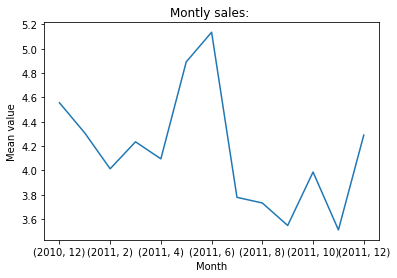

In [707]:
monthly_sales_mean = df2['Sale'].groupby([df2.index.year, df2.index.month]).mean().plot()
plt.title('Montly sales: ')
plt.xlabel('Month')
plt.ylabel('Mean value')

Text(0, 0.5, 'Sum')

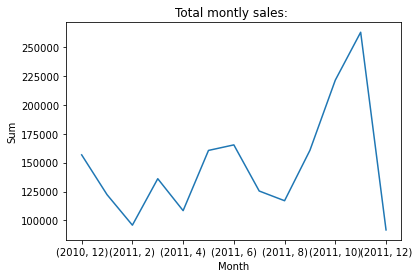

In [708]:
monthly_sales_total = df2['Sale'].groupby([df2.index.year, df2.index.month]).sum().plot()
plt.title('Total montly sales: ')
plt.xlabel('Month')
plt.ylabel('Sum')

**Weekly**

Text(0, 0.5, 'Mean')

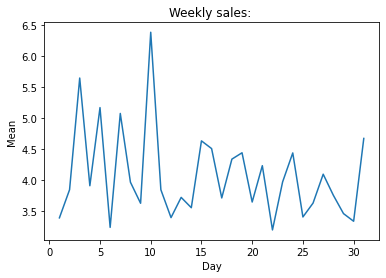

In [709]:
weekly_sales_mean = df2['Sale'].groupby(df2.index.day).mean().plot()
plt.title('Weekly sales: ')
plt.xlabel('Day')
plt.ylabel('Mean')

Text(0, 0.5, 'Sum')

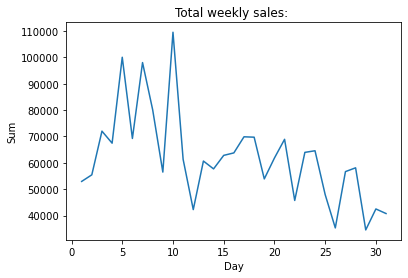

In [710]:
weekly_sales_total = df2['Sale'].groupby(df2.index.day).sum().plot()
plt.title('Total weekly sales: ')
plt.xlabel('Day')
plt.ylabel('Sum')

**Daily**

Text(0, 0.5, 'Mean value')

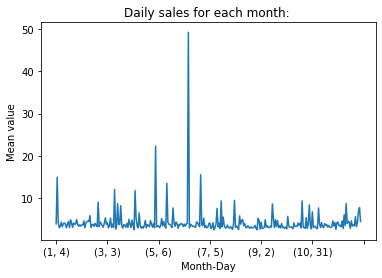

In [711]:
daily_sales_mean = df2['Sale'].groupby([df2.index.month, df2.index.day]).mean().plot()
plt.title('Daily sales for each month: ')
plt.xlabel('Month-Day')
plt.ylabel('Mean value')

Text(0, 0.5, 'Sum')

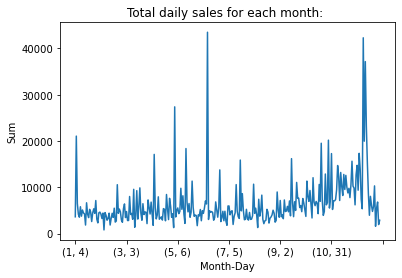

In [712]:
daily_sales_total = df2['Sale'].groupby([df2.index.month, df2.index.day]).sum().plot()
plt.title('Total daily sales for each month: ')
plt.xlabel('Month-Day')
plt.ylabel('Sum')

**Hourly**

Text(0, 0.5, 'Sum')

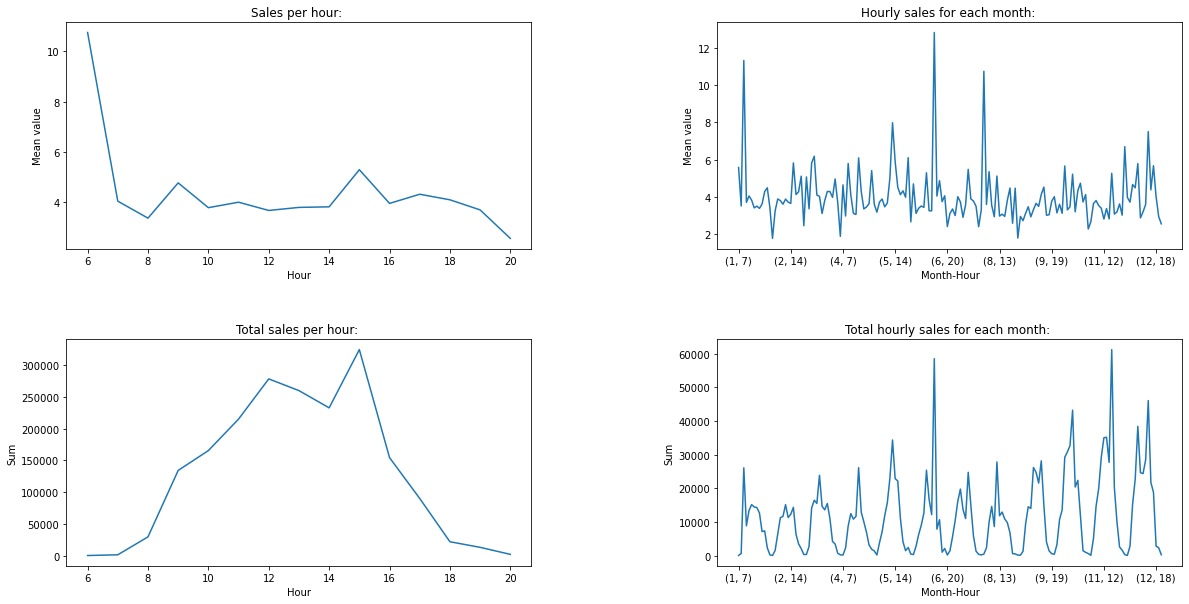

In [713]:
# Set up a grid of plots:
fig = plt.figure(figsize=(20, 10))
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Plot mean sales per hour
plt.subplot2grid(fig_dims, (0, 0))
hourly_sales_mean = df2['Sale'].groupby(df2.index.hour).mean().plot()
plt.title('Sales per hour: ')
plt.xlabel('Hour')
plt.ylabel('Mean value')

# Plot total sales per hour
plt.subplot2grid(fig_dims, (1, 0))
hourly_sales_total = df2['Sale'].groupby(df2.index.hour).sum().plot()
plt.title('Total sales per hour: ')
plt.xlabel('Hour')
plt.ylabel('Sum')

# Plot mean sales per hour for each month
plt.subplot2grid(fig_dims, (0, 1))
hourly_sales_mean = df2['Sale'].groupby([df2.index.month, df2.index.hour]).mean().plot()
plt.title('Hourly sales for each month: ')
plt.xlabel('Month-Hour')
plt.ylabel('Mean value')

# Plot total sales per hour for each month
# evidente regolarità !!
plt.subplot2grid(fig_dims, (1, 1))
hourly_sales_total = df2['Sale'].groupby([df2.index.month, df2.index.hour]).sum().plot()
plt.title('Total hourly sales for each month: ')
plt.xlabel('Month-Hour')
plt.ylabel('Sum')

#### *Country* plots

In [714]:
df2.groupby(df2['CustomerCountry']).median()

,Sale,CustomerID,Qta
CustomerCountry,,,
Australia,1.79,12415,24
Austria,1.95,12374,9
Bahrain,3.81,12355,6
Belgium,1.95,12407,10
Brazil,3.32,12769,10
Canada,1.65,17444,12
Channel Islands,2.55,14936,10
Cyprus,2.95,12370,5
Czech Republic,1.45,12781,24


Text(0, 0.5, 'Sales median')

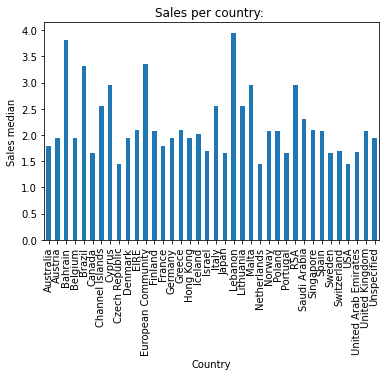

In [715]:
df2['Sale'].groupby(df2['CustomerCountry']).median().plot(kind='bar')
plt.title('Sales per country: ')
plt.xlabel('Country')
plt.ylabel('Sales median')

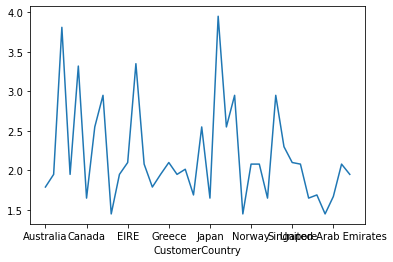

In [716]:
median_sale_country.plot()

#### *Customers* plots

How many customers for each country:

In [717]:
print("Country \t Number of customers")
df2['CustomerID'].groupby(df2['CustomerCountry']).count().sort_values()

Country 	 Number of customers


CustomerCountry
Saudi Arabia                10
Bahrain                     19
Czech Republic              30
Brazil                      32
Lithuania                   35
Lebanon                     45
RSA                         58
European Community          61
United Arab Emirates        68
Malta                      127
Hong Kong                  138
Greece                     146
Canada                     151
Iceland                    182
Singapore                  229
Israel                     269
USA                        291
Unspecified                340
Poland                     341
Japan                      358
Denmark                    389
Austria                    401
Sweden                     462
Cyprus                     622
Finland                    695
Channel Islands            758
Italy                      803
Norway                    1086
Australia                 1259
Portugal                  1495
Switzerland               1932
Belgium                

Text(0, 0.5, 'Number of customers')

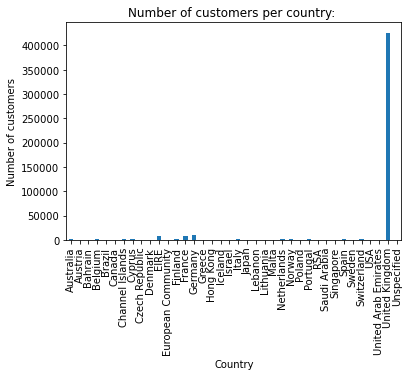

In [718]:
df2['CustomerID'].groupby(df2['CustomerCountry']).count().plot(kind='bar')
plt.title('Number of customers per country: ')
plt.xlabel('Country')
plt.ylabel('Number of customers')

In [719]:
# ELIMINARE UK per fare confronto fra gli altri paesi
customers_without_UK = df2['CustomerID'].groupby(df2['CustomerCountry']).count()
customers_without_UK = customers_without_UK.drop(['United Kingdom'])

Text(0, 0.5, 'Customers')

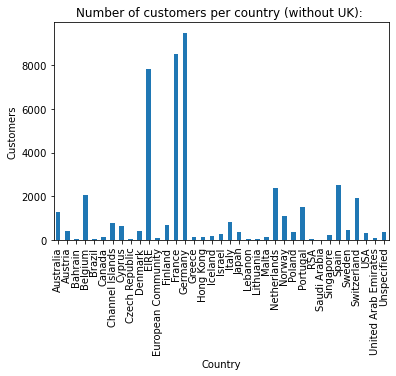

In [720]:
customers_without_UK.plot(kind='bar')
plt.title('Number of customers per country (without UK): ')
plt.xlabel('Country')
plt.ylabel('Customers')

Shopping sessions for each customer: how many times each customer has bought something.

In [721]:
print("Customer: \t How many shopping sessions")
df2['BasketID'].groupby(df2['CustomerID']).count()

Customer: 	 How many shopping sessions


CustomerID
12346      2
12347    182
12348     31
12349     73
12350     17
        ... 
18281      7
18282     13
18283    756
18287     70
18288    138
Name: BasketID, Length: 4373, dtype: int64

Sales per customer: how much each customer has spent in total.

In [722]:
print("Customer \t Total sale")
df2['Sale'].groupby(df2['CustomerID']).sum()

Customer 	 Total sale


CustomerID
12346      2.08
12347    481.21
12348    178.71
12349    605.10
12350     65.30
          ...  
18281     39.36
18282     62.68
18283   1220.93
18287    104.55
18288   8260.08
Name: Sale, Length: 4373, dtype: float64

Sales per country: in which country the sales are high/low.

In [723]:
print("Country \t Total sale")
df2['Sale'].groupby(df2['CustomerCountry']).sum()

Country 	 Total sale


CustomerCountry
Australia                 4054.75
Austria                   1701.52
Bahrain                     86.57
Belgium                   7540.13
Brazil                     142.60
Canada                     910.58
Channel Islands           3738.55
Cyprus                    3920.07
Czech Republic              88.15
Denmark                   1266.95
EIRE                     40280.78
European Community         294.05
Finland                   3786.85
France                   42960.34
Germany                  37666.00
Greece                     713.29
Hong Kong                 8260.08
Iceland                    481.21
Israel                     983.93
Italy                     3879.39
Japan                      814.86
Lebanon                    242.44
Lithuania                   99.44
Malta                      666.01
Netherlands               6492.55
Norway                    6529.06
Poland                    1422.27
Portugal                 12955.19
RSA                        248.1

In [724]:
# ELIMINARE UK per fare confronto fra gli altri paesi
sales_without_UK = df2['Sale'].groupby(df2['CustomerCountry']).sum()
sales_without_UK = sales_without_UK.drop(['United Kingdom'])

Text(0, 0.5, 'Total sales (expenditure)')

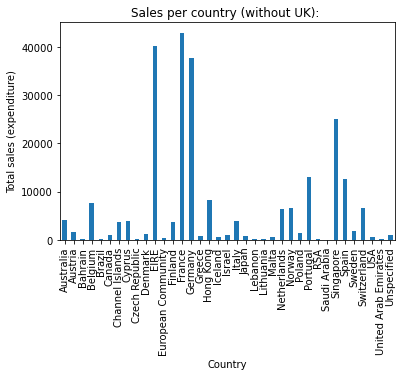

In [725]:
sales_without_UK.plot(kind='bar')
plt.title('Sales per country (without UK): ')
plt.xlabel('Country')
plt.ylabel('Total sales (expenditure)')

# New features extraction
We now find and extract new features useful for describing the customer profile and his purchasing behavior.

For each customer, we extract the following indicators:
- ***I***: the total number of items purchased by a customer during the period of
observation.
- ***Iu***: the number of distinct items bought by a customer in the period of
observation.
- ***Imax***: the maximum number of items purchased by a customer during a
shopping session
- ***E***: the Shannon entropy on the purchasing behaviour of the customer



First of all, we extract the number of distinct customer:

In [726]:
print("There are", df.CustomerID.unique().size, "distinct customers. ") 

There are 4373 distinct customers. 


## "I" indicator


In [782]:
# total number of items purchased by a customer
I = df['Qta'].groupby(df['CustomerID']).sum()
print("\t How many items he bought \n", I)

	 How many items he bought 
 CustomerID
12346       0
12347    2458
12348    2341
12349     631
12350     197
         ... 
18281      54
18282      98
18283    1397
18287    1586
18288    2592
Name: Qta, Length: 4373, dtype: int64


We now check the distribution of this new indicator, unsing the **density plot**.

(-4000.0, 10000.0, 0.0, 0.0004)

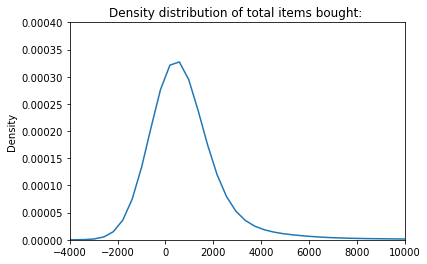

In [728]:
# DENSITY PLOT
I.plot.kde()
plt.title('Density distribution of total items bought: ')
plt.axis([-4000,10000,0,0.0004])

*Osservazioni sul tipo di distribuzione*

## "Iu" indicator

In [891]:
# number of distinct items bought by a customer
Iu = df['ProdID'].groupby(df['CustomerID']).unique()
#Iu = pd.DataFrame(Iu)
Iu

CustomerID
12346                                              [23166]
12347    [85116, 22375, 71477, 22492, 22771, 22772, 227...
12348    [84992, 22951, 84991, 21213, 22616, 21981, 219...
12349    [23112, 23460, 21564, 21411, 21563, 22131, 221...
12350    [21908, 22412, 79066K, 79191C, 22348, 84086C, ...
                               ...                        
18281    [22037, 22716, 22028, 23007, 23008, 23209, 22467]
18282    [21270, 23187, 23295, 22089, 21108, 21109, 224...
18283    [22356, 20726, 22384, 22386, 20717, 20718, 850...
18287    [22755, 22754, 22753, 22756, 22758, 22757, 227...
18288    [85183A, 21058, 21967, 21981, 22551, 21947, 21...
Name: ProdID, Length: 4373, dtype: object

In [892]:
items = pd.DataFrame(data = {'TotalProd': []})
items

,TotalProd


In [893]:
# counting uniques
for i in Iu:
    items = items.append({'TotalProd': i.size}, ignore_index=True)
items.TotalProd

0        1.00
1      103.00
2       22.00
3       73.00
4       17.00
        ...  
4368     7.00
4369    12.00
4370   263.00
4371    59.00
4372   109.00
Name: TotalProd, Length: 4373, dtype: float64

In [896]:
items['CustomerID'] = Iu.index
items.index = items.CustomerID
items

,TotalProd,CustomerID
CustomerID,,
12346,1.00,12346
12347,103.00,12347
12348,22.00,12348
12349,73.00,12349
12350,17.00,12350
...,...,...
18281,7.00,18281
18282,12.00,18282
18283,263.00,18283


(-1000.0, 1500.0, 0.0, 0.002)

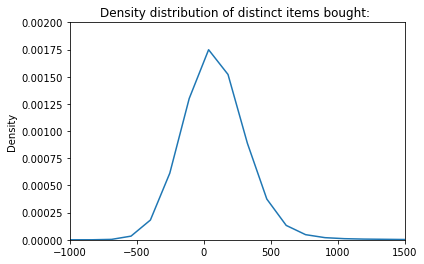

In [730]:
# DENSITY PLOT
Iu.plot.kde()
plt.title('Density distribution of distinct items bought: ')
plt.axis([-1000,1500,0,0.002])

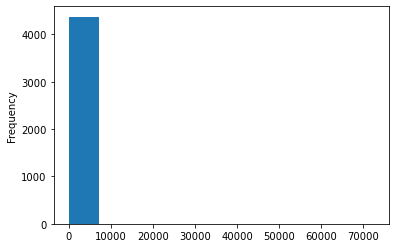

In [731]:
# FREQUENCY
Iu.plot(kind='hist')

## "Imax" indicator

In [732]:
# maximum number of items purchased by a customer during a shopping session
#Imax = df.Qta.groupby([df.CustomerID, df.BasketID]).sum().sort_values()
#Imax
df.BasketID.groupby(df.CustomerID).unique()

CustomerID
12346                                    [541431, C541433]
12347    [537626, 542237, 549222, 556201, 562032, 57351...
12348                     [539318, 541998, 548955, 568172]
12349                                             [577609]
12350                                             [543037]
                               ...                        
18281                                             [556464]
18282                            [562525, C562808, 580173]
18283    [540350, 541854, 545079, 550957, 554157, 55673...
18287                             [554065, 570715, 573167]
18288    [541975, C546557, 546558, 549738, 553148, 5576...
Name: BasketID, Length: 4373, dtype: object

## "E" indicator

The value of entropy is between 0 and log(n).
NB. *n* in this case is the number of distinct customers, i.e. 4373.

In [749]:
import math
print("Maximum value for Entropy: ", math.log(4373)) 
# in this case every event has the same probability -> confusion, not informative at all

Maximum value for Entropy:  8.38320455141292


In [733]:
# Shannon entropy on the purchasing behaviour of the customer

C:\Users\Diletta\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


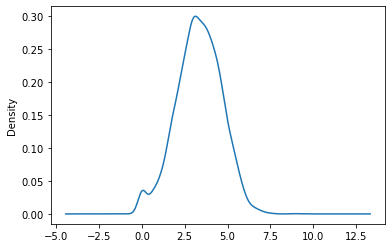

In [750]:
# COMPUTING SHANNON ENTROPY
g_sum = df.groupby('CustomerID')['Sale'].transform('sum')
values = df['Sale']/g_sum
df['Entropy'] = -(values*np.log(values))

# ENTROPY DISTRIBUTION
df1 = df.groupby('CustomerID',as_index=False,sort=False)['Entropy'].sum()
df1['Entropy'].plot.kde()

## Additional indicators
### Sales per customer

(-6000.0, 6000.0, 0.0, 0.0004)

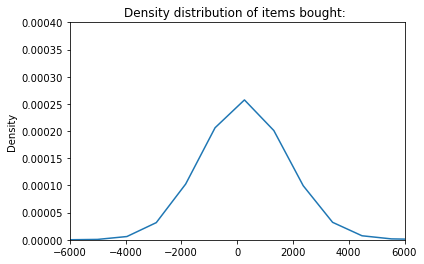

In [794]:
# DENSITY PLOT
total_spent = df['Sale'].groupby(df['CustomerID']).sum()
total_spent.plot(kind='kde')
plt.title('Density distribution of items bought: ')
plt.axis([-6000,6000,0,0.0004])

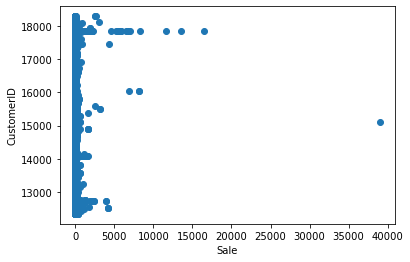

In [735]:
# SCATTER PLOT
plt.scatter(df['Sale'], df['CustomerID'])
plt.xlabel('Sale')
plt.ylabel('CustomerID')
plt.show()

**Is that value an outlier ???**

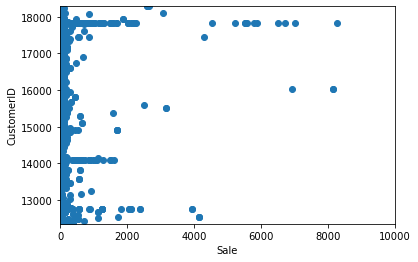

In [736]:
# "zoomming" the interesting part
plt.scatter(df['Sale'], df['CustomerID'])
plt.xlabel('Sale')
plt.ylabel('CustomerID')
plt.axis([0,10000,df['CustomerID'].min(),df['CustomerID'].max()])
plt.show()

Ciò che emerge dal profilo del customer è che molte persone fanno spese piccole mentre poche persone fanno spese più grandi.
Ciò è confermato dal grafico delle frequenze:

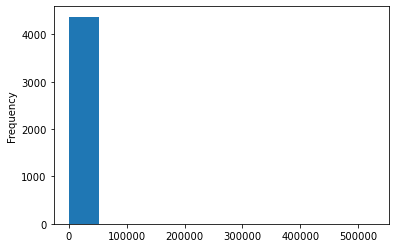

In [737]:
# FREQUENCY
df['Sale'].groupby(df['CustomerID']).sum().plot(kind='hist')

 ### Shopping sessions per customer

In [801]:
shopping_sess = df['BasketID'].groupby(df['CustomerID']).count()
shopping_sess

CustomerID
12346      2
12347    182
12348     31
12349     73
12350     17
        ... 
18281      7
18282     13
18283    756
18287     70
18288    138
Name: BasketID, Length: 4373, dtype: int64

# New Dataset


In [760]:
#customer_data = {'Customer': [], 'TotalQta': []}
#customers = pd.DataFrame(data=customer_data)
#customers.Customer = df.CustomerID.unique()

In [882]:
# creating a new dataframe starting from "I" indicator
customers = pd.DataFrame(I)
customers = customers.rename(columns={"Qta": "TotalQta"})

In [897]:
# adding info from "Iu" indicator
customers['TotalProd'] = items.TotalProd

In [898]:
# adding info from addictional indicators

total_spent = pd.DataFrame(total_spent)
customers['TotalSpent'] = total_spent.Sale

shopping_sess = pd.DataFrame(shopping_sess)
customers['ShopSessions'] = shopping_sess.BasketID

In [899]:
customers

,TotalQta,TotalSpent,ShopSessions,TotalProd
CustomerID,,,,
12346,0,2.08,2,1.00
12347,2458,481.21,182,103.00
12348,2341,178.71,31,22.00
12349,631,605.10,73,73.00
12350,197,65.30,17,17.00
...,...,...,...,...
18281,54,39.36,7,7.00
18282,98,62.68,13,12.00
18283,1397,1220.93,756,263.00


In [900]:
# Exporting the new dataset in CSV format
customers.to_csv(r'customers.csv', index = False)

## Correlations 

In [901]:
customers.corr()

,TotalQta,TotalSpent,ShopSessions,TotalProd
TotalQta,1.00,0.51,0.54,0.58
TotalSpent,0.51,1.00,0.99,0.60
ShopSessions,0.54,0.99,1.00,0.66
TotalProd,0.58,0.60,0.66,1.00


In [902]:
df.corr(method='spearman')

,Sale,CustomerID,Qta,Entropy
Sale,1.00,0.07,-0.40,0.31
CustomerID,0.07,1.00,-0.27,-0.29
Qta,-0.40,-0.27,1.00,0.10
Entropy,0.31,-0.29,0.10,1.00


In [903]:
df.corr(method='kendall')

,Sale,CustomerID,Qta,Entropy
Sale,1.00,0.05,-0.30,0.23
CustomerID,0.05,1.00,-0.19,-0.19
Qta,-0.30,-0.19,1.00,0.06
Entropy,0.23,-0.19,0.06,1.00
